In [1]:
!pip install kagglehub==0.3.12

In [2]:
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import kagglehub
import zipfile
import os
import shutil
from PIL import Image
import pickle

import xgboost as xg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [4]:
# Mount Google drive
drive.mount('/content/drive')

Mounted at /content/drive


**Crop Yield Prediction**

In [5]:
# Download latest version
dataset_dir = kagglehub.dataset_download("madhankumar789/crop-yield-and-environmental-factors-2014-2023")


# Find the CSV file in the directory
csv_file = None
for file in os.listdir(dataset_dir):
    if file.endswith('.csv'):
        csv_file = os.path.join(dataset_dir, file)
        break

if csv_file:
    # Read the CSV
    pred = pd.read_csv(csv_file)

else:
    print("No CSV file found in the dataset directory")

100%|██████████| 1.42M/1.42M [00:00<00:00, 110MB/s]

Extracting files...


In [6]:
# Show dataframe
pred.head()

,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.50,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,2014-01-01,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2014-01-01,Rice,Peaty,5.50,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
3,2014-01-01,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000
4,2014-01-01,Soybean,Peaty,5.50,16.110395,80.000000,7.696070,49.5,45.0,38.5,32.970413,22.166667


In [ ]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36520 entries, 0 to 36519
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          36520 non-null  object 
 1   Crop_Type     36520 non-null  object 
 2   Soil_Type     36520 non-null  object 
 3   Soil_pH       36520 non-null  float64
 4   Temperature   36520 non-null  float64
 5   Humidity      36520 non-null  float64
 6   Wind_Speed    36520 non-null  float64
 7   N             36520 non-null  float64
 8   P             36520 non-null  float64
 9   K             36520 non-null  float64
 10  Crop_Yield    36520 non-null  float64
 11  Soil_Quality  36520 non-null  float64
dtypes: float64(9), object(3)
memory usage: 3.3+ MB


In [7]:
pred["Crop_Type"].unique()

array(['Wheat', 'Corn', 'Rice', 'Barley', 'Soybean', 'Cotton',
       'Sugarcane', 'Tomato', 'Potato', 'Sunflower'], dtype=object)

In [8]:
crop_list = ['Wheat', 'Sugarcane', 'Corn', 'Rice', 'Potato']

# Filter the DataFrame
pred = pred[pred["Crop_Type"].isin(crop_list)]
pred["Crop_Type"].unique()

array(['Wheat', 'Corn', 'Rice', 'Sugarcane', 'Potato'], dtype=object)

In [9]:
pred.drop(columns = "Date", inplace = True)
pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18260 entries, 0 to 36518
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Crop_Type     18260 non-null  object 
 1   Soil_Type     18260 non-null  object 
 2   Soil_pH       18260 non-null  float64
 3   Temperature   18260 non-null  float64
 4   Humidity      18260 non-null  float64
 5   Wind_Speed    18260 non-null  float64
 6   N             18260 non-null  float64
 7   P             18260 non-null  float64
 8   K             18260 non-null  float64
 9   Crop_Yield    18260 non-null  float64
 10  Soil_Quality  18260 non-null  float64
dtypes: float64(9), object(2)
memory usage: 1.7+ MB


In [10]:
pred.head()

,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,Wheat,Peaty,5.5,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,Corn,Loamy,6.5,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,Rice,Peaty,5.5,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
6,Sugarcane,Saline,8.0,13.533004,80.000000,9.910484,84.5,66.0,54.0,0.000000,17.041667
8,Potato,Peaty,5.5,18.895963,80.000000,6.696707,60.5,45.0,31.5,54.259727,22.833333


In [11]:
# Get int datatype features
pred_int = pred.select_dtypes(include = ["float64"])

# Get descriptive statistics
pred_int.describe()

,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
count,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000,18260.000000
mean,6.602451,23.811898,74.259154,10.006339,71.960871,54.964458,40.769743,27.559699,38.888039
std,0.821474,8.906242,6.747989,3.001657,10.037026,8.970187,8.614989,26.492321,18.379978
min,5.500000,-2.390846,45.851089,-1.157606,55.000000,40.000000,27.000000,0.000000,13.916667
25%,6.250000,17.161352,69.758505,7.965251,65.000000,48.000000,35.000000,0.000000,22.833333
50%,6.500000,22.911403,77.088597,9.986377,71.500000,55.000000,40.500000,23.783572,39.083333
75%,6.750000,30.241495,80.000000,12.042389,78.000000,60.000000,45.000000,47.352618,53.083333
max,8.000000,54.148911,80.000000,21.115730,91.000000,72.000000,60.000000,136.711982,74.333333


In [16]:
pred_int.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18260 entries, 0 to 36518
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Soil_pH       18260 non-null  float64
 1   Temperature   18260 non-null  float64
 2   Humidity      18260 non-null  float64
 3   Wind_Speed    18260 non-null  float64
 4   N             18260 non-null  float64
 5   P             18260 non-null  float64
 6   K             18260 non-null  float64
 7   Crop_Yield    18260 non-null  float64
 8   Soil_Quality  18260 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


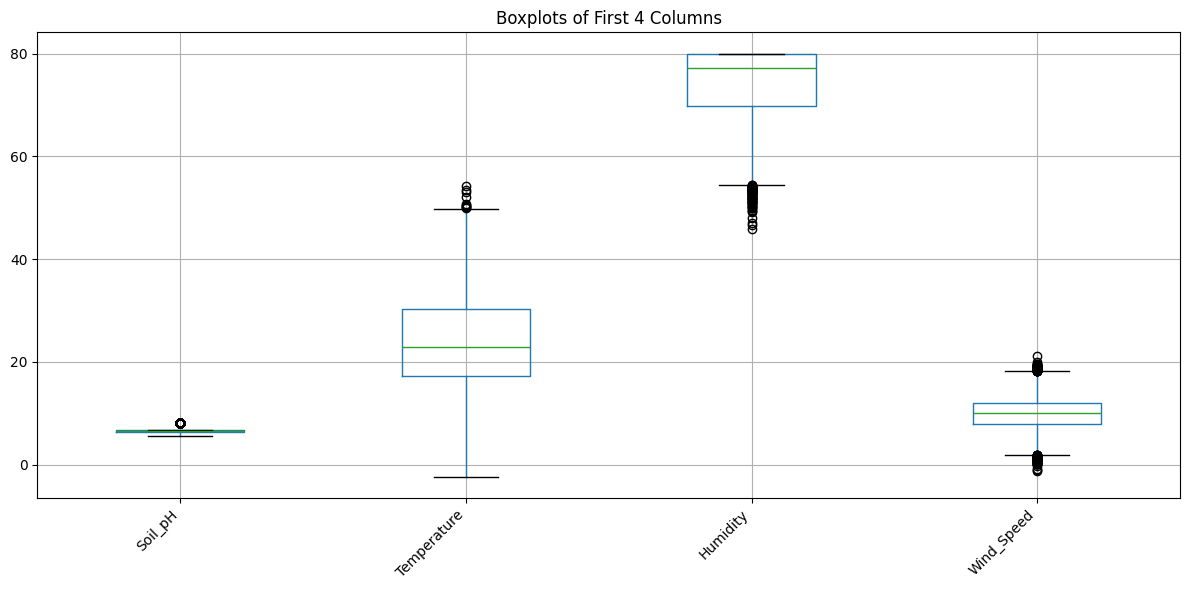

In [17]:
# Select the first 4 columns
cols_to_plot = list(pred_int.columns[:4])  # Convert Index to list

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplots
pred_int.boxplot(column=cols_to_plot, ax=ax)

# Customize the plot
plt.title("Boxplots of First 4 Columns")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

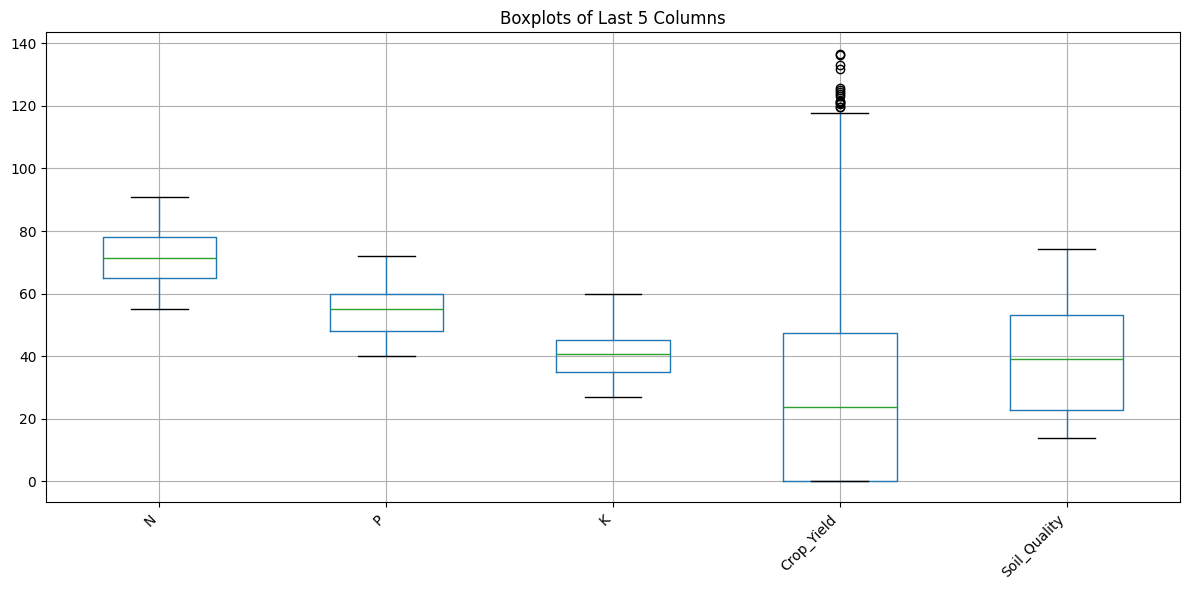

In [18]:
# Select the last 5 columns
cols_to_plot = list(pred_int.columns[4:])  # Convert Index to list

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplots
pred_int.boxplot(column=cols_to_plot, ax=ax)

# Customize the plot
plt.title("Boxplots of Last 5 Columns")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

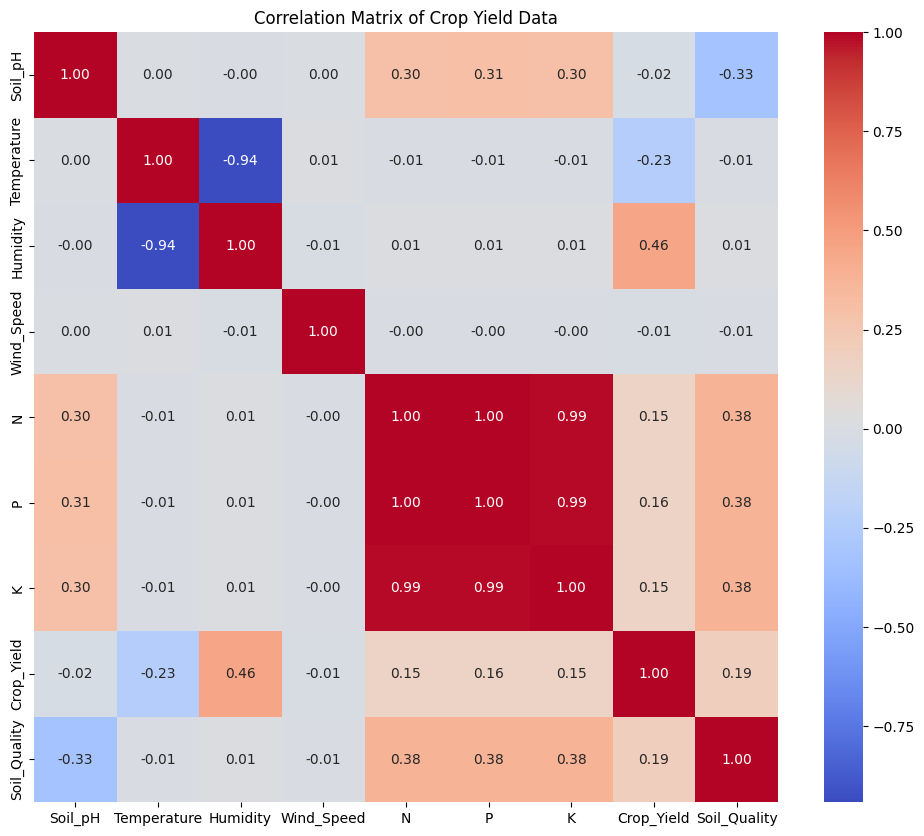

In [ ]:
# Calculate the correlation matrix
correlation_matrix = pred_int.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Crop Yield Data')
plt.show()

In [19]:
# Encode categorical features
pred['Crop_Type'] = pred['Crop_Type'].astype('category').cat.codes
pred['Soil_Type'] = pred['Soil_Type'].astype('category').cat.codes
pred.head()

,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,4,2,5.5,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.000000,22.833333
1,0,1,6.5,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
2,2,2,5.5,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.000000,27.333333
6,3,3,8.0,13.533004,80.000000,9.910484,84.5,66.0,54.0,0.000000,17.041667
8,1,2,5.5,18.895963,80.000000,6.696707,60.5,45.0,31.5,54.259727,22.833333


In [20]:
# Model splitting

X = pred.drop(columns = "Crop_Yield")
y = pred["Crop_Yield"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [21]:
# Training and evaluating a Baseline Model
mae_baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
mae_baseline = round(mae_baseline, 1)
print(f"The Benchmark of models, 'Baseline Mean Absolute Error' is: {mae_baseline:.2f} metric tons per hectare")

The Benchmark of models, 'Baseline Mean Absolute Error' is: 22.80 metric tons per hectare


In [ ]:
# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Make predictions on the test set
linear_y_pred = linear_model.predict(X_test)

# Evaluate the model using mean_absolute_error
linear_mae = mean_absolute_error(y_test, linear_y_pred)
print(f"Linear Regression Mean Absolute Error: {linear_mae:.2f} metric tons per hectare")

Linear Regression Mean Absolute Error: 12.77 metric tons per hectare


In [ ]:
# XGB Regressor
xg_model = xg.XGBRegressor(random_state = 42)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Make predictions on the test set
xg_y_pred = xg_model.predict(X_test)

# Evaluate the model using mean_absolute_error
xg_mae = mean_absolute_error(y_test, xg_y_pred)
print(f"XGBoost Mean Absolute Error: {xg_mae:.2f} metric tons per hectare")


XGBoost Mean Absolute Error: 2.53 metric tons per hectare


In [ ]:
# Decision Tree Regressor
decision_model = DecisionTreeRegressor(random_state = 42)
decision_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
# Make predictions on the test set
decision_y_pred = decision_model.predict(X_test)

# Evaluate the model using mean_absolute_error
decision_mae = mean_absolute_error(y_test, decision_y_pred)
print(f"Decision Tree Regressor Mean Absolute Error: {decision_mae:.2f} metric tons per hectare")

Decision Tree Regressor Mean Absolute Error: 3.16 metric tons per hectare


In [22]:
# Random Forest Regressor
random_model = RandomForestRegressor(random_state = 42)
random_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [23]:
# Make predictions on the test set
random_y_pred = random_model.predict(X_test)

# Evaluate the model using mean_absolute_error
random_mae = mean_absolute_error(y_test, random_y_pred)
print(f"Random Forest Regressor Mean Absolute Error: {random_mae:.2f} metric tons per hectare")

Random Forest Regressor Mean Absolute Error: 2.41 metric tons per hectare


In [ ]:
# Support Vector Regressor
svr_model = SVR()
svr_model.fit(X_train, y_train)

SVR()

In [ ]:
# Make predictions on the test set
svr_y_pred = svr_model.predict(X_test)

# Evaluate the model using mean_absolute_error
svr_mae = mean_absolute_error(y_test, svr_y_pred)
print(f"Support Vector Regressor Mean Absolute Error: {svr_mae:.2f} metric tons per hectare")

Support Vector Regressor Mean Absolute Error: 15.96 metric tons per hectare


In [ ]:
# KNeighbors Regressor
knr_model = KNeighborsRegressor()
knr_model.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
# Make predictions on the test set
knr_y_pred = knr_model.predict(X_test)

# Evaluate the model using mean_absolute_error
knr_mae = mean_absolute_error(y_test, knr_y_pred)
print(f"KNeighbors Regressor Mean Absolute Error: {knr_mae:.2f} metric tons per hectare")

KNeighbors Regressor Mean Absolute Error: 2.70 metric tons per hectare


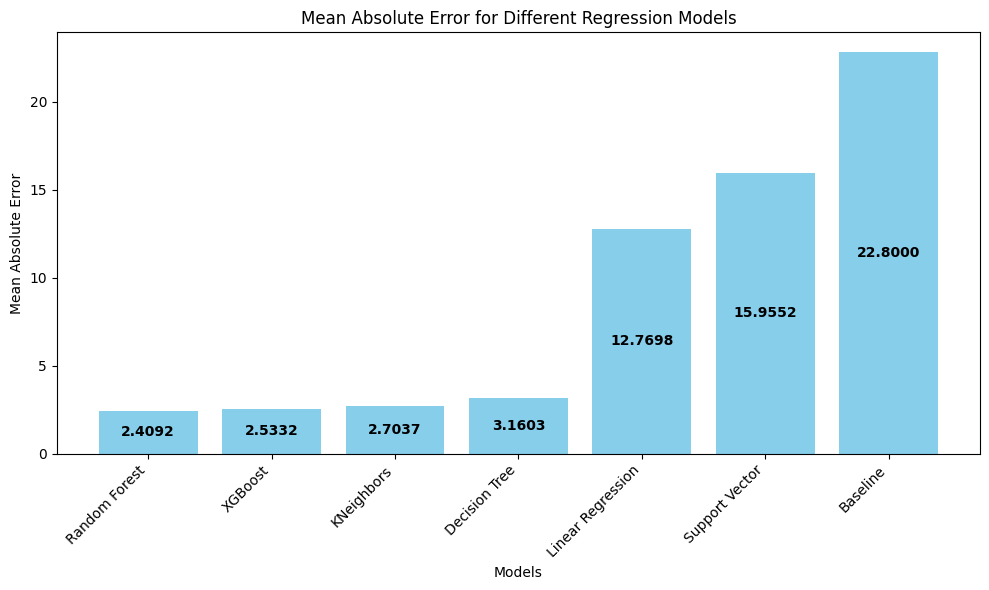

In [ ]:
mae_values = {
    'Baseline': mae_baseline,
    'XGBoost': xg_mae,
    'Linear Regression': linear_mae,
    'Decision Tree': decision_mae,
    'Random Forest': random_mae,
    'Support Vector': svr_mae,
    'KNeighbors': knr_mae
}

# Convert to DataFrame for easy sorting
mae_df = pd.DataFrame.from_dict(mae_values, orient='index', columns=['MAE'])
mae_df = mae_df.sort_values('MAE', ascending=True)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(mae_df.index, mae_df['MAE'], color='skyblue')

# Add labels and title
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error for Different Regression Models")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{height:.4f}',  # Format to 4 decimal places
             ha='center', va='center',
             color='black', fontweight='bold')

plt.show()

In [ ]:
# Tunning Random Forest Regressor hyperparameters
random_model = RandomForestRegressor(random_state = 42)

param_grid = {
    'n_estimators': np.arange(1000, 1600, 200),
    'max_depth': np.arange(10, 50, 10),
    #'min_samples_split': np.arange(2, 10, 2),
    #'min_samples_leaf': np.arange(1, 5, 1)
}

grid_search = GridSearchCV(estimator = random_model, param_grid = param_grid,
                           cv = 5, n_jobs = 2, verbose = 0)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_random_model = grid_search.best_estimator_

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': np.int64(20), 'n_estimators': np.int64(1400)}


In [ ]:
# view the results
print(grid_search.cv_results_)

{'mean_fit_time': array([ 69.42266593,  77.18978643,  91.35260653,  96.37048836,
       113.4781127 , 133.35368495,  97.24907122, 117.87874818,
       136.38082094,  96.367202  , 115.83267269, 133.38541064]), 'std_fit_time': array([4.61409708, 0.42051081, 1.06318841, 2.25248795, 1.04710678,
       0.43749469, 1.06836848, 2.0249127 , 1.58931393, 0.67939924,
       0.49306707, 4.46036972]), 'mean_score_time': array([0.75229578, 0.68222423, 0.83788128, 1.09058475, 1.66097803,
       1.50853505, 1.33589396, 1.91489487, 2.12361584, 1.35008321,
       2.04583116, 1.83304567]), 'std_score_time': array([0.2387573 , 0.02698252, 0.08356625, 0.04734483, 0.4618044 ,
       0.01964328, 0.38399276, 0.46045693, 0.61353501, 0.4847077 ,
       0.46902718, 0.3954569 ]), 'param_max_depth': masked_array(data=[10, 10, 10, 20, 20, 20, 30, 30, 30, 40, 40, 40],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=999999), 

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select and reorder columns for better readability
cols_to_show = [
    'rank_test_score',
    'param_n_estimators',
    'param_max_depth',
    'mean_test_score',
    'std_test_score',
    'mean_fit_time',
    'std_fit_time'
]

# Create a sorted and formatted display DataFrame
display_df = (
    results_df[cols_to_show]
    .sort_values('rank_test_score')
    .rename(columns={
        'rank_test_score': 'Rank',
        'param_n_estimators': 'n_estimators',
        'param_max_depth': 'max_depth',
        'mean_test_score': 'Mean Score',
        'std_test_score': 'Std Score',
        'mean_fit_time': 'Fit Time (s)',
        'std_fit_time': 'Fit Time Std'
    })
)

# Display first 5 rows
display_df.head(5).style.format({
    'Mean Score': '{:.2f}',
    'Std Score': '{:.2f}',
    'Fit Time (s)': '{:.1f}',
    'Fit Time Std': '{:.1f}'
})

,Rank,n_estimators,max_depth,Mean Score,Std Score,Fit Time (s),Fit Time Std
5,1,1400,20,0.98,0.00,133.4,0.4
4,2,1200,20,0.98,0.00,113.5,1.0
3,3,1000,20,0.98,0.00,96.4,2.3
6,4,1000,30,0.98,0.00,97.2,1.1
8,5,1400,30,0.98,0.00,136.4,1.6


In [ ]:
# Save the best random forest model
best_random_path = "/content/drive/My Drive/AI for Smart Urban Farming/yield_best_random_model.pkl"
#with open(best_random_path, 'wb') as f:
 #   pickle.dump(best_random_model, f)
print(f"Best Model saved to {best_random_path}")

# Load
# with open(best_random_path, 'rb') as f:
#     best_random_model = pickle.load(f)

Best Model saved to {best_random_path}


In [ ]:
random_y_pred = best_random_model.predict(X_test)

# Evaluate the model using mean_absolute_error
random_mae = mean_absolute_error(y_test, random_y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, random_y_pred)):.2f}")
print(f"Coefficient of Determination (R² Score): {r2_score(y_test, random_y_pred):.2f}")
print(f"Random Forest Regressor Mean Absolute Error: {random_mae:.2f} metric tons per hectare")

Root Mean Squared Error: 4.13
Coefficient of Determination (R² Score): 0.98
Random Forest Regressor Mean Absolute Error: 2.40 metric tons per hectare


In [ ]:
# Get feature importances
importances = best_random_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
importance_df.set_index("Feature", inplace=True)

# Print the top 7 feature importance
importance_df.head(7)

,Importance
Feature,
Temperature,0.578438
Humidity,0.157534
Crop_Type,0.137793
Soil_Quality,0.074276
N,0.018519
Soil_Type,0.008551
Wind_Speed,0.008362


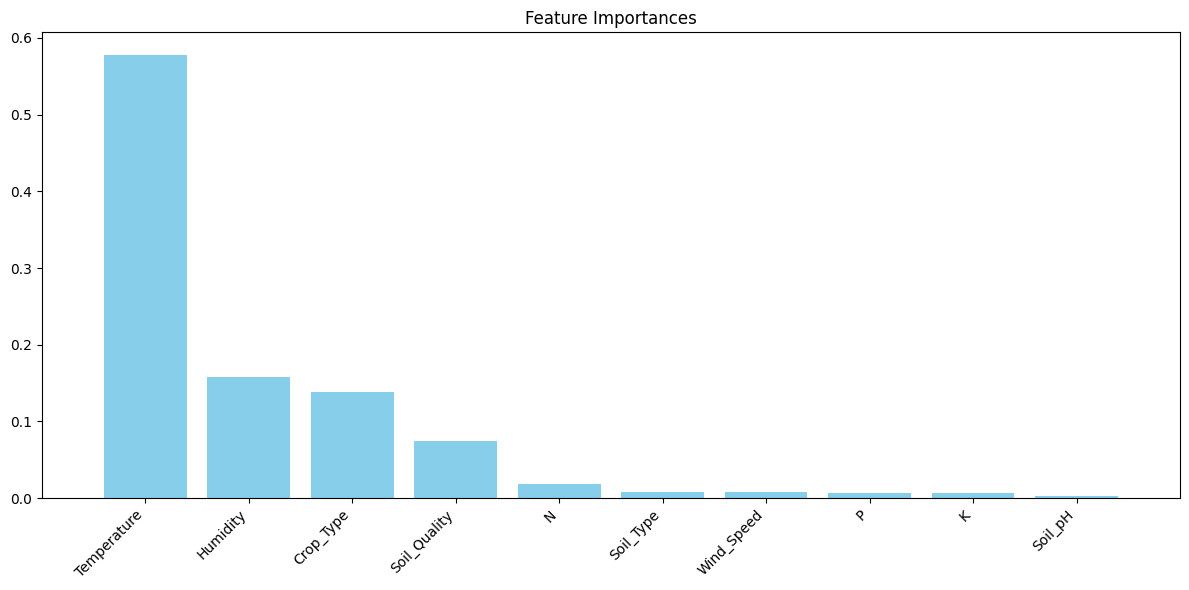

In [ ]:
# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()